# Lab Seven: RNNs


LJ Brown, Joe McGuire, Henry Warren, Mike Lefebvre, Xingming Qu


## 1. Business Understanding



Given the scale and popularity of social forums as platforms for communication, a machine learning based approach to auto-moderation may be necessary to help ensure that these platforms are moderated as prescribed by their builders. With the ability to automatically classify text bodies by topic, social forums could: 
- Automatically tag content, and therefore allow users to filter it
<br>
- Automatically flag content with certain labels for human review 
<br>
- Automatically require human approval before making content publicly visible if it is in a certain category
<br>
- Automatically block content from being posted if it is in a certain category
<br>

So, in this exercise we will compare and contrast multiple methods of logistic regression optimization in order to create a multi-class classifier, where the target classes are different sports topics present in the BBCSport dataset. In building an effective classifier for topics in a text corpus, and showing that such a classifier is sufficiently accurate for non-critical grouping tasks (~90+%), we believe that our findings would serve as a proof of concept that auto-moderation of user generated text is possible, and a beneficial application of machine learning to social forums (e.g. Reddit, Quora, YouTube). 

We believe that 90% general accuracy would be an acceptable rate of accuracy for this prediction task because it would be easy to augment the classifications with a combination of crowd sourced and in-house (human) moderation and because the consequences of false positives and negatives in this context are not overly severe. However, it is also necessary to note that accuracy may not necessary be the best method to evaluate models of this sort, as in cases where the data set is imbalanced, accuracy would likely give a poor reflection of the actual performance of our model.

## 2. Preparation(Dataset Selection)

In this lab, we use the dataset from our Lab1.

Dataset: BBCSport

All rights, including copyright, in the content of the original articles are owned by the BBC.

Consists of 737 documents from the BBC Sport website corresponding to sports news articles in five topical areas from 2004-2005.
Class Labels: 5 (0-athletics, 1-cricket, 2-football, 3-rugby, 4-tennis)

Reference: http://mlg.ucd.ie/datasets/bbc.html

### 2.1 Read document data
Read in document data as strings using Python. Read the data as raw text documents.

In [1]:
# read txt file
def readtxt(filename):    
    with open(filename, 'r',encoding='gb18030', errors='ignore') as file_to_read:
        content = file_to_read.read()
    return content

In [2]:
#read all the documents 
import numpy as np
import pandas as pd
import os,shutil
import matplotlib
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns
from scipy import stats
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import keras
warnings.filterwarnings('ignore')

########################################Change your folder first#############################
folder='bbcsport' 
folders=os.listdir(folder)
print('Document catagories are ',folders) 

summary_text=[]
for item in folders:  # find each catagory's dir
    each_catagory=[]
    print('now reading',item,'docs...')
    path=os.path.join(folder,item)
    docs=os.listdir(path)
    for doc in docs:  #find each doc in a folder
        doc_dir= os.path.join(path, doc)
        each_catagory.append(readtxt(doc_dir))
    summary_text.append(each_catagory)
print('==============================')    
it=0
for c in summary_text:
    print('There are',len(c),folders[it],'documents')
    it+=1
    
##summary_text contains the whole corpus, first index is catagories and second index is the number of document

Using TensorFlow backend.


Document catagories are  ['athletics', 'cricket', 'football', 'rugby', 'tennis']
now reading athletics docs...
now reading cricket docs...
now reading football docs...
now reading rugby docs...
now reading tennis docs...
There are 101 athletics documents
There are 124 cricket documents
There are 265 football documents
There are 147 rugby documents
There are 100 tennis documents


### 2.2 Pre-Processing

#### 2.2.1 Verify data quality: 
The following functions are designed to remove words from the vocabulary that are not relevant, or to find ones that should not be included. 

Stop words need to be removed, because stop words like 'the','a','an' are so common in language and usually have no specific meaning.
We also need to remove redundant words that have different capitalization. Eg. APPLE, apple. Therefore, we make every word to lowercase.

Besides, Punctuations are also removed

In [3]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

# remove stop words from a document. Return a list of words that contain no stop words.
def removeStopWords(text):
    cleanwordlist = [word for word in text.lower().split() if word not in stoplist]
    return cleanwordlist

# remove Punctuations from a document. Return a list of words that contain no Punctuations.
def removePunctuations(string):   
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    # remove punctuation from the string
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct


In [4]:
it=0
cleanWordLlist=[]
for c in summary_text: # traverse each catagories and process
    print('Now cleaning',folders[it],'documents.','Total number',len(c))
    it+=1
    each_catagory_clean=[]
    for doc in c: #traverse each document
        cleaned_words=removeStopWords(doc) #we get a list of words
        cleaned_string=""   # we need to concatenate all these words
        for word in cleaned_words:
            cleaned_string=cleaned_string+word+' '
        
        cleaned_string=removePunctuations(cleaned_string) # remove Punctuations 
        each_catagory_clean.append(cleaned_string)
    cleanWordLlist.append(each_catagory_clean)  
print('Finished')

Now cleaning athletics documents. Total number 101
Now cleaning cricket documents. Total number 124
Now cleaning football documents. Total number 265
Now cleaning rugby documents. Total number 147
Now cleaning tennis documents. Total number 100
Finished


In [5]:
# Compare cleaned doc and non-cleaned doc
print(cleanWordLlist[0][0]) 
print('\r\n----------------------------------------------------------------------------------------------------\r\n')
print(summary_text[0][0])     

claxton hunting first major medal british hurdler sarah claxton confident win first major medal next months european indoor championships madrid 25yearold already smashed british record 60m hurdles twice season setting new mark 796 seconds win aaas title i quite confident said claxton but take race comes as long keep training much think chance medal claxton national 60m hurdles title past three years struggled translate domestic success international stage now scotlandborn athlete owns equal fifthfastest time world year last weeks birmingham grand prix claxton left european medal favourite russian irina shevchenko trailing sixth spot first time claxton preparing campaign hurdles  could explain leap form previous seasons 25yearold also contested long jump since moving colchester london refocused attentions claxton see new training regime pays dividends european indoors take place 56 march 

-------------------------------------------------------------------------------------------------

### 2.3  Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  

In [6]:
corpus=[]
for each_catagory in cleanWordLlist:
    for each_doc in each_catagory:
        corpus.append(each_doc)
print('There are', len(corpus), 'document in the corpus')

There are 737 document in the corpus


We first create a dictionary and go through all the words in corpus, giving each word a label and then add them into the dictionary.

In [7]:
dictionary={}
count=1

for each_doc in corpus:
    word_list=each_doc.split()
    for word in word_list:
        if word not in dictionary:
            dictionary[word]=count
            count=count+1


In [8]:
# from random import shuffle
# def shuffleDict(orderdict):
#     x = orderdict
#     values = list( x.values() )
#     shuffle(values)
#     y = dict(zip(x.keys(), values))
#     return y
# dictionary=shuffleDict(dictionary)

In [9]:
print('Vocabulary size is', len(dictionary))
top_words=len(dictionary)+1
it=0
## show some items
for i,j in dictionary.items():
    print(i,j)
    if it==8:
        break
    it=it+1

Vocabulary size is 15031
claxton 1
hunting 2
first 3
major 4
medal 5
british 6
hurdler 7
sarah 8
confident 9


After that we go through the dictionary again, replacing each word with its label

In [10]:
encoded_corpus=[]
for each_doc in corpus:
    encoded_doc=[]
    word_list=each_doc.split()
    for word in word_list:
        encoded_doc.append(dictionary[word])
    encoded_corpus.append(encoded_doc)

In [11]:
print(corpus[0])
print('---------------------------------------------------------------------------------------------------------')
print(encoded_corpus[0])

claxton hunting first major medal british hurdler sarah claxton confident win first major medal next months european indoor championships madrid 25yearold already smashed british record 60m hurdles twice season setting new mark 796 seconds win aaas title i quite confident said claxton but take race comes as long keep training much think chance medal claxton national 60m hurdles title past three years struggled translate domestic success international stage now scotlandborn athlete owns equal fifthfastest time world year last weeks birmingham grand prix claxton left european medal favourite russian irina shevchenko trailing sixth spot first time claxton preparing campaign hurdles  could explain leap form previous seasons 25yearold also contested long jump since moving colchester london refocused attentions claxton see new training regime pays dividends european indoors take place 56 march 
--------------------------------------------------------------------------------------------------

Next we need to truncate and pad input sequences to be the same length

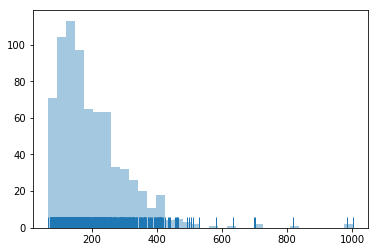

In [12]:
length=[]
for e in encoded_corpus:
    length.append(len(e))
sns.distplot(length, kde=False, rug=True);

From the above figure we can see that the length of most documents is less than 500. So we decide to set our max_review_length=500

In [13]:
from keras.preprocessing import sequence
max_review_length = 500
pad_encoded_corpus = sequence.pad_sequences(encoded_corpus, maxlen=max_review_length)

In [14]:
print(type(pad_encoded_corpus),pad_encoded_corpus.shape)
print(type(pad_encoded_corpus[0]),pad_encoded_corpus[0].shape)
print('Vocabulary size:', np.max(pad_encoded_corpus))
# print(y_train.shape, np.min(y_train), np.max(y_train))
NUM_CLASSES = 5

<class 'numpy.ndarray'> (737, 500)
<class 'numpy.ndarray'> (500,)
Vocabulary size: 15031


In [15]:
## make label list
label_length=[len(c) for c in summary_text]
label_list=[]
category=0
for i in label_length:
    for j in range(i):
        label_list.append(category)
    category+=1

y=np.array(label_list) # y contains each document's label
print(y.shape)
y_ohe=keras.utils.to_categorical(y, NUM_CLASSES) # also make the one hot for Y
print(y_ohe.shape)

(737,)
(737, 5)


### 2.4 Describe the final dataset that is used for classification
The final dataset contains 737 documents. Each documents is a 500-d vector, which was generated by sequence.pad_sequences.<br/>
There are 5 classes:<br/>
There are 101 athletics documents<br/>
There are 124 cricket documents<br/>
There are 265 football documents<br/>
There are 147 rugby documents<br/>
There are 100 tennis documents

## 3. Evaluation

### 3.1  Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance

In researching why accuracy is not a great evaluation metric, we discovered what's known as the "Accuracy Paradox," stating:

> Accuracy paradox for predictive analytics states that predictive models with a given level of accuracy may have greater predictive power than models with higher accuracy. <br/>
Source: https://en.wikipedia.org/wiki/Accuracy_paradox

The source is then perscriptive in its description, stating:
> It may be better to avoid the accuracy metric in favor of other metrics such as **precision** and **recall**. <br/>
Source: https://en.wikipedia.org/wiki/Accuracy_paradox

Given this paradox, accuracy may mistakenly perceived as a success metric, when a mix of precision and recall might be the better performance metric. Further research corroborated this hunch:
> Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.<br/>
Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

Therefore, we chose the f1_score method to evaluate our algorithm's generalization performance. The f1_score algorithm (with accuracy parameter set to "macro" because we have a class imbalance) operates as a weighted average of precision and recall that calculates metrics globally by counting the total true positives, false negatives, and false positives.<br/>
Source: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

### 3.2 Choose the method you will use for dividing your data into training and testing 

We used stratified K-fold cross validation because we have imbalanced classes in the test set and training set, as such, the proportion of classes should be consistent with the original data set. We decided on using 10 folds to get a large sampling of the performance of our algorithm on multiple subsamples, while still limiting the amount of computation time required for this project, as even testing on the 10 folds took multiple hours.

## 4. Modeling

### 4.1  Investigate at least two different recurrent network architectures
We will investigate LSTM and GRU. For each network we will use an embedding layer from scratch<br/>

In [16]:
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import keras
import itertools

In [17]:
#plot history function.
def plotresult(History):
    %matplotlib inline
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(History.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(History.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(History.history['loss'])
    plt.ylabel('categorical_crossentropy Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(History.history['val_loss'])
    plt.xlabel('epochs')

In [18]:
b_size=64
FinalE=30
Patience=3
Kfold=10

Create a function which takes model name(LSTM,GRU), embedding size, state dimension, and dropout_rate.........<br/>
We also add a checkpoint to save the best model.

In [19]:
def trainModelAndGetBestModel(model_name,namestr,EMBED_SIZE,S_demension,dropout_num,E,X_train, y_train_ohe,X_test, y_test_ohe):
    input_holder = Input(shape=(pad_encoded_corpus.shape[1], ))
    input_embed = Embedding(top_words, # input dimension (max int of OHE)
                    EMBED_SIZE, # output dimension size
                    input_length=max_review_length)(input_holder) # number of words in each sequence

    x = model_name(S_demension, dropout=dropout_num, recurrent_dropout=dropout_num)(input_embed)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    my_model=Model(inputs=input_holder,outputs=x)
    my_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    name=namestr+'_EMBED_SIZE'+str(EMBED_SIZE)+'_State_demension'+str(S_demension)+'_dropout'+str(dropout_num)+'.h5'
    checkpoint = ModelCheckpoint(name, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    history=my_model.fit(X_train, y_train_ohe, epochs=E, batch_size=b_size, validation_data=(X_test, y_test_ohe),
               callbacks=[EarlyStopping(monitor='val_loss', patience=Patience),checkpoint],verbose=0 )

    my_model.load_weights(name)
    return my_model,history

#### 4.1.1 Adjust hyper-parameters of the networks as needed to improve generalization performance with cross validation

In [20]:
def cross_val(M_name,M_str,E_S,S_D,D_N,ep):

    cv = StratifiedShuffleSplit(n_splits=Kfold,test_size=0.2)
    fold=cv.split(pad_encoded_corpus,y_ohe)
    X_train_Stratified = []
    X_test_Stratified = []
    y_train_Stratified = []
    y_test_Stratified = []
    y_label_train=[]
    y_label_test=[]
    for train_index, test_index in fold:
        X_train_Stratified.append(pad_encoded_corpus[train_index])
        X_test_Stratified.append(pad_encoded_corpus[test_index])
        y_train_Stratified.append(y_ohe[train_index])
        y_test_Stratified.append(y_ohe[test_index])
        y_label_train.append(y[train_index])
        y_label_test.append(y[test_index])

    score=[]

    saved_models=[]
    for i in range(len(X_train_Stratified)):
        print('training fold',i)
        model,history=trainModelAndGetBestModel(M_name,M_str,E_S,S_D,D_N,ep,X_train_Stratified[i], 
                                        y_train_Stratified[i],X_test_Stratified[i], y_test_Stratified[i])
        yhat = np.argmax(model.predict(X_test_Stratified[i]),axis=1)
        score.append(f1_score(y_label_test[i],yhat,average='macro'))
    return score,history
        

In [21]:
def evaluateModel(model_name,eph):
    EMBED_SIZE=[25,50]
    S_demension=[20,40,60]
    dropout_num=[0.25]
    MODEL=model_name
    # MODEL=[(GRU,'GRU')]

    para_list=[]
    all_scores=[]
    saved_history=[]
    for e in EMBED_SIZE:
        for s in S_demension:
            for d in dropout_num:
                for m, n in MODEL:
                    print('Now traing model with parameter:',e,s,d,n)
                    cross_v_score,history=cross_val(m,n,e,s,d,eph)
                    para_list.append([e,s,d])
                    all_scores.append(cross_v_score)
                    saved_history.append(history)
    return para_list,all_scores,saved_history
            
    

Turn hyper parameters with cross validation on LSTM and GRU

 find LSTM and GRU with best parameter 

In [22]:
LSTM_para,LSTM_scores,LSTM_history=evaluateModel([(LSTM,'LSTM')],FinalE)
GRU_para,GRU_scores,GRU_history=evaluateModel([(GRU,'GRU')],FinalE)

Now traing model with parameter: 25 20 0.25 LSTM
training fold 0
training fold 1
training fold 2
training fold 3
training fold 4
training fold 5
training fold 6
training fold 7
training fold 8
training fold 9
Now traing model with parameter: 25 40 0.25 LSTM
training fold 0
training fold 1
training fold 2
training fold 3
training fold 4
training fold 5
training fold 6
training fold 7
training fold 8
training fold 9
Now traing model with parameter: 25 60 0.25 LSTM
training fold 0
training fold 1
training fold 2
training fold 3
training fold 4
training fold 5
training fold 6
training fold 7
training fold 8
training fold 9
Now traing model with parameter: 50 20 0.25 LSTM
training fold 0
training fold 1
training fold 2
training fold 3
training fold 4
training fold 5
training fold 6
training fold 7
training fold 8
training fold 9
Now traing model with parameter: 50 40 0.25 LSTM
training fold 0
training fold 1
training fold 2
training fold 3
training fold 4
training fold 5
training fold 6
tra

Visualize the performance of training and validation sets versus the training iterations for the best LSTM model. 

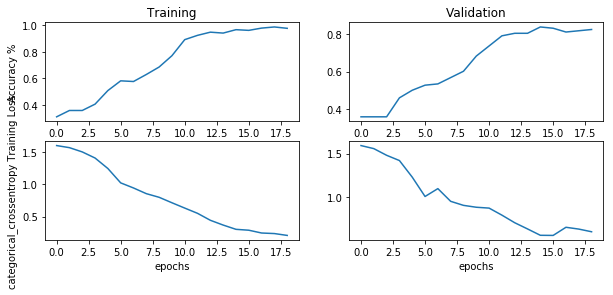

In [23]:
LSTM_mean_scores=np.mean(LSTM_scores,axis=1)
LSTM_index=np.argmax(LSTM_mean_scores)
LSTM_best_model_history=LSTM_history[LSTM_index]
plotresult(LSTM_best_model_history)

Visualize the performance of training and validation sets versus the training iterations for the best GRU model. 

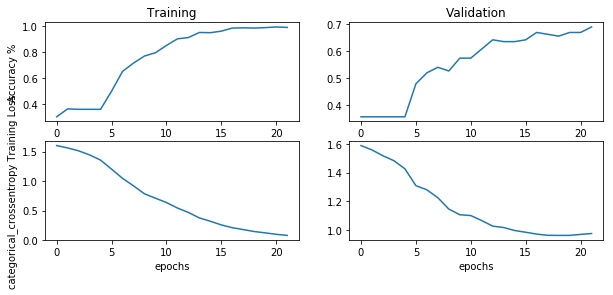

In [24]:
GRU_mean_scores=np.mean(GRU_scores,axis=1)
GRU_index=np.argmax(GRU_mean_scores)
GRU_best_model_history=GRU_history[GRU_index]
plotresult(GRU_best_model_history)

Plot the performances of LSTM with different parameters<br/>
The order of the Parameter size is Embedding size, state demension, dropout rate

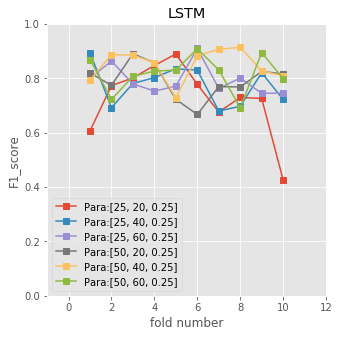

In [25]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')
length=range(1,len(LSTM_scores[0])+1)
for i in range(len(LSTM_scores)):    
    plt.plot(length,LSTM_scores[i],'s-',label='Para:'+str(LSTM_para[i]))

plt.title("LSTM")
plt.xlabel("fold number")
plt.ylabel("F1_score")
plt.legend(loc = "best")

plt.ylim(0, 1)
plt.xlim(-1, 10+2)
plt.show()


Plot the performances of GRU with different parameters<br/>
Parameters order is Embedding size, state dimension, dropout rate

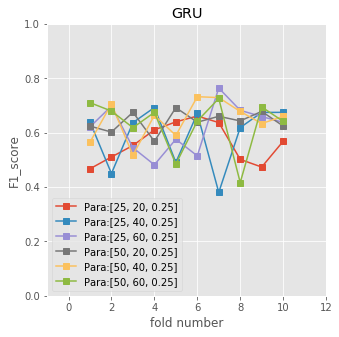

In [26]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')
length=range(1,len(GRU_scores[0])+1)
for i in range(len(GRU_scores)):
    
    plt.plot(length,GRU_scores[i],'s-',label='Para:'+str(GRU_para[i]))

plt.title("GRU")
plt.xlabel("fold number")
plt.ylabel("F1_score")
plt.legend(loc = "best")

plt.ylim(0, 1)
plt.xlim(-1, 10+2)
plt.show()


Using the best RNN parameters and architecture, add a second recurrent chain to your RNN

In [27]:
#Print the best para
blstm=np.mean(LSTM_scores[LSTM_index])
bgru=np.mean(GRU_scores[GRU_index])
print('Best LSTM f1',blstm)
print('Best GRU f1',bgru)
print('Para LSTM',LSTM_para[LSTM_index])
print('Para GRU',GRU_para[GRU_index])

Best LSTM f1 0.8493891376625493
Best GRU f1 0.6476297704555535
Para LSTM [50, 40, 0.25]
Para GRU [50, 40, 0.25]


In [28]:
MODEL=[(LSTM,'LSTM'),(GRU,'GRU')]
flag=0
if blstm<bgru:
    flag=1
print('We will use',MODEL[flag][1])

if flag==0:
    best_P=LSTM_para[LSTM_index]
else:
    best_P=GRU_para[GRU_index] 
    
best_Em=best_P[0]
best_Sd=best_P[1]
best_Dp=best_P[2]
print('We will use Embedding Size=',best_Em,'State Demension=',best_Sd,'Dropout rate=',best_Dp)

We will use LSTM
We will use Embedding Size= 50 State Demension= 40 Dropout rate= 0.25


In [29]:
def trainTwoLayerModelAndGetBestModel(model_name,namestr,EMBED_SIZE,S_demension,dropout_num,E,X_train, y_train_ohe,X_test, y_test_ohe):
    input_holder = Input(shape=(pad_encoded_corpus.shape[1], ))
    input_embed = Embedding(top_words, # input dimension (max int of OHE)
                    EMBED_SIZE, # output dimension size
                    input_length=max_review_length)(input_holder) # number of words in each sequence

    x = model_name(S_demension, dropout=dropout_num, recurrent_dropout=dropout_num,return_sequences=True)(input_embed)
    x = model_name(S_demension, dropout=dropout_num, recurrent_dropout=dropout_num)(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    my_model=Model(inputs=input_holder,outputs=x)
    my_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    name=namestr+'_EMBED_SIZE'+str(EMBED_SIZE)+'_State_demension'+str(S_demension)+'_dropout'+str(dropout_num)+'.h5'
    checkpoint = ModelCheckpoint(name, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    history=my_model.fit(X_train, y_train_ohe, epochs=E, batch_size=b_size, validation_data=(X_test, y_test_ohe),
               callbacks=[EarlyStopping(monitor='val_loss', patience=Patience),checkpoint],verbose=0 )

    my_model.load_weights(name)
    return my_model,history

In [30]:
def two_layer_cross_val(M_name,M_str,E_S,S_D,D_N,ep):

    cv = StratifiedShuffleSplit(n_splits=Kfold,test_size=0.2)
    fold=cv.split(pad_encoded_corpus,y_ohe)
    X_train_Stratified = []
    X_test_Stratified = []
    y_train_Stratified = []
    y_test_Stratified = []
    y_label_train=[]
    y_label_test=[]
    for train_index, test_index in fold:
        X_train_Stratified.append(pad_encoded_corpus[train_index])
        X_test_Stratified.append(pad_encoded_corpus[test_index])
        y_train_Stratified.append(y_ohe[train_index])
        y_test_Stratified.append(y_ohe[test_index])
        y_label_train.append(y[train_index])
        y_label_test.append(y[test_index])

    score=[]

    saved_models=[]
    for i in range(len(X_train_Stratified)):
        print('using two layer', M_str,'....training fold',i)
        model,history=trainTwoLayerModelAndGetBestModel(M_name,M_str,E_S,S_D,D_N,ep,X_train_Stratified[i], 
                                        y_train_Stratified[i],X_test_Stratified[i], y_test_Stratified[i])
        yhat = np.argmax(model.predict(X_test_Stratified[i]),axis=1)
        score.append(f1_score(y_label_test[i],yhat,average='macro'))
    return score,history
        

In [31]:
two_layer_score,two_layer_history=two_layer_cross_val(MODEL[flag][0],MODEL[flag][1],best_Em,best_Sd,best_Dp,FinalE)

using two layer LSTM ....training fold 0
using two layer LSTM ....training fold 1
using two layer LSTM ....training fold 2
using two layer LSTM ....training fold 3
using two layer LSTM ....training fold 4
using two layer LSTM ....training fold 5
using two layer LSTM ....training fold 6
using two layer LSTM ....training fold 7
using two layer LSTM ....training fold 8
using two layer LSTM ....training fold 9


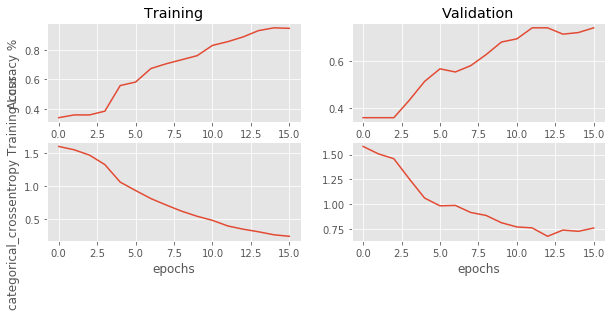

In [32]:
plotresult(two_layer_history)

In [33]:
best_LSTM_score=LSTM_scores[LSTM_index]
best_GRU_score=GRU_scores[GRU_index]

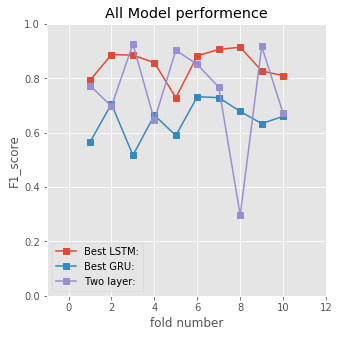

In [34]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')
length=range(1,len(best_LSTM_score)+1)

plt.plot(length,best_LSTM_score,'s-',label='Best LSTM:')
plt.plot(length,best_GRU_score,'s-',label='Best GRU:')
plt.plot(length,two_layer_score,'s-',label='Two layer:')

plt.title("All Model performence")
plt.xlabel("fold number")
plt.ylabel("F1_score")
plt.legend(loc = "best")

plt.ylim(0, 1)
plt.xlim(-1, 10+2)
plt.show()

In [35]:
blstm=np.mean(LSTM_scores[LSTM_index])
bgru=np.mean(GRU_scores[GRU_index])
btwoLayer=np.mean(two_layer_score)
print('Best LSTM f1',blstm)
print('Best GRU f1',bgru)
print('Best two layer', MODEL[flag][1],'f1',btwoLayer)

Best LSTM f1 0.8493891376625493
Best GRU f1 0.6476297704555535
Best two layer LSTM f1 0.7449986413654124


Use proper statistical comparison techniques to determine which method(s) is (are) superior<br/>
LSTM VS GRU

In [41]:
#===================================================
# Enter your code below

evals1=np.array(GRU_scores[GRU_index])
evals2=np.array(LSTM_scores[LSTM_index])
t = 2.26/np.sqrt(10)
e12 = (1-evals1)-(1-evals2)
stdtot = np.std(e12)
dbar = np.mean(e12)
print("Range of confidence interval at 95% from", dbar-t*stdtot, "to ", dbar+t*stdtot)

print('Since the interval does not include 0, we could say : yes, model 1 and 2 are statistically different from one another \
and we can tell LSTM is Better')



Range of confidence interval at 95% from 0.15653612389524155 to  0.24698261051875006
Since the interval does not include 0, we could say : yes, model 1 and 2 are statistically different from one another and we can tell LSTM is Better


Use proper statistical comparison techniques to determine which method(s) is (are) superior<br/>
LSTM VS Two-layer LSTM

In [51]:
evals1=np.array(two_layer_score)
evals2=np.array(LSTM_scores[LSTM_index])
t = 2.26/np.sqrt(10)
e12 = (1-evals1)-(1-evals2)
stdtot = np.std(e12)
dbar = np.mean(e12)
print("Range of confidence interval at 95% from", dbar-t*stdtot, "to ", dbar+t*stdtot)

print('Since the interval does include 0, we could say : no, model 1 and 2 are not statistically different from one another \
and we can not tell which one is better')


Range of confidence interval at 95% from -0.0444331359451455 to  0.25321412853941916
Since the interval does include 0, we could say : no, model 1 and 2 are not statistically different from one another and we can not tell which one is better


Although the two layer LSTM achieved the highest f1 in fold 3, it fluctuated greatly. We still tend to use LSTM

## 5.Exceptional Work 

In [17]:
from sklearn.model_selection import train_test_split
Y=y
X_train,X_test,y_train,y_test = train_test_split(pad_encoded_corpus,Y,test_size=0.2)
y_test_ohe=keras.utils.to_categorical(y_test, NUM_CLASSES)
y_train_ohe=keras.utils.to_categorical(y_train, NUM_CLASSES)

EMBED_SIZE = 50

input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=max_review_length)(input_holder) # number of words in each sequence


x = LSTM(100,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='softmax')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn.fit(X_train, y_train_ohe, epochs=30, batch_size=64, validation_data=(X_test, y_test_ohe),
       callbacks=[EarlyStopping(monitor='val_loss', patience=2)] )
rnn.summary()

Train on 589 samples, validate on 148 samples
Epoch 1/30
589/589 [==============================] - 7s 12ms/step - loss: 1.5986 - acc: 0.3463 - val_loss: 1.5767 - val_acc: 0.3716
Epoch 2/30
589/589 [==============================] - 6s 10ms/step - loss: 1.5437 - acc: 0.3565 - val_loss: 1.5089 - val_acc: 0.3716
Epoch 3/30
589/589 [==============================] - 6s 9ms/step - loss: 1.4955 - acc: 0.3565 - val_loss: 1.4838 - val_acc: 0.3716
Epoch 4/30
589/589 [==============================] - 7s 11ms/step - loss: 1.4010 - acc: 0.3565 - val_loss: 1.3729 - val_acc: 0.3716
Epoch 5/30
589/589 [==============================] - 7s 12ms/step - loss: 1.1853 - acc: 0.5144 - val_loss: 1.1814 - val_acc: 0.5270
Epoch 6/30
589/589 [==============================] - 6s 10ms/step - loss: 0.9834 - acc: 0.6893 - val_loss: 1.0815 - val_acc: 0.5473
Epoch 7/30
589/589 [==============================] - 6s 10ms/step - loss: 0.8526 - acc: 0.7487 - val_loss: 1.0530 - val_acc: 0.6554
Epoch 8/30
589/589 [====

In [19]:
weight=rnn.get_layer('embedding_1').get_weights()[0]

In [20]:
weight.shape

(15032, 50)

In [21]:
# perform T-SNE
from sklearn import manifold, datasets
tsne = manifold.TSNE(n_components=2)
X = weight

# target_names = folders
%time X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}. Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

Wall time: 3min 51s
Org data dimension is 50. Embedded data dimension is 2


In [22]:
X_tsne.shape

(15032, 2)

In [31]:
it=0
maxdisplay=160
word=[]
number=[]
for i,j in dictionary.items():
    word.append(i)
    number.append(j)
      

random_index=[np.random.randint(0, top_words) for i in range(maxdisplay)]
selected_words=[word[i] for i in random_index]
selected_words_label=[number[i] for i in random_index]

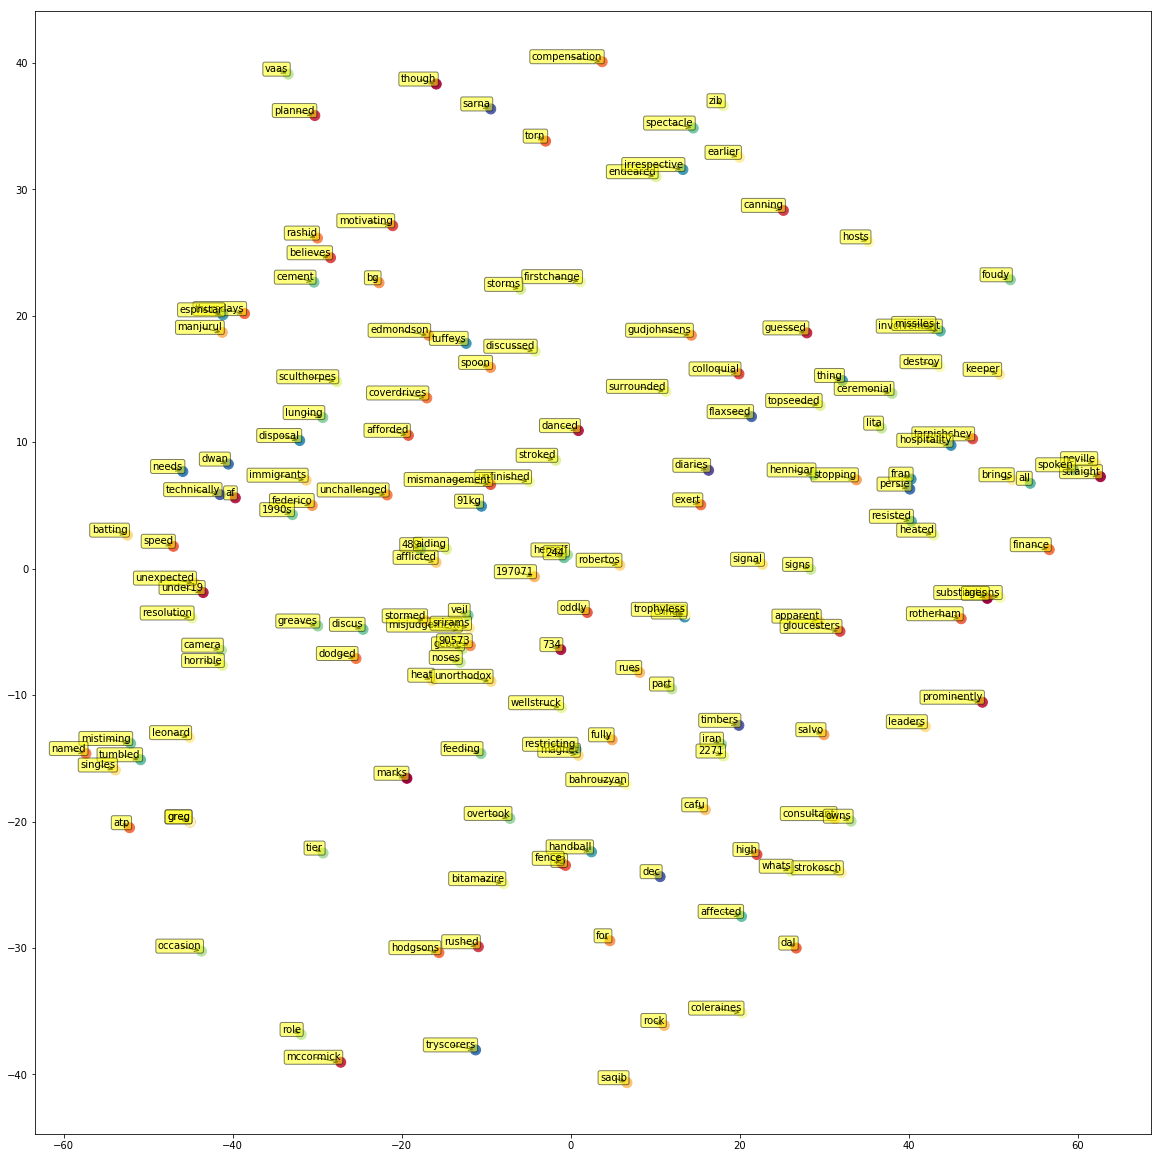

In [32]:
N = maxdisplay
data = np.random.random((N, 4))

emeding_vectors = X_tsne[selected_words_label]
#labels = ['point{0}'.format(i) for i in range(N)]
labels = selected_words
plt.figure(figsize=(20, 20))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    emeding_vectors[:, 0], emeding_vectors[:, 1], marker='o', c=data[:, 2], s=100,
    cmap=plt.get_cmap('Spectral'))


for label, x, y in zip(labels, emeding_vectors[:, 0], emeding_vectors[:, 1]):
    noise=np.random.randint(-20, 20)
    plt.annotate(
        label,
        xy=(x, y), xytext=(-0, 0),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

We can see in the middle of the picture the numbers are close to each other (244,1971071,734,489)
signal and signs are close to each other as well as prominently and leaders.

### 5.1 Try to interpret what each dimension reflects (in your own words). That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding. 

The word embedding is to embed words from a high sparse dimension to a low dimension space.In this space, words with similar meaning tend to stay close to each other. When we use t-SNE to reduce dimension to 2d for visualization, each dimension does not have a specific meaning,it is more like a weighted sum from the pervious dimension.